In [2]:
from rasterio.windows import Window

from ..old_files.transformations import raster_scripts
from util.config import GetConfig

config = GetConfig()

filename = 'D:/RESEARCH/SATELLITE/DEM/eu_dem_v11_E40N20.tif'
filename = '/mnt/z/RESEARCH/SATELLITE/DEM/eu_dem_v11_E40N20.tif'

raster_scripts.printRasterFileStats(filename)

w = raster_scripts.loadWindowOfRasterFile(filename, Window(0, 0, config["WINDOW"]["DEM"], config["WINDOW"]["DEM"]))

raster_scripts.plotArray(w)


ModuleNotFoundError: No module named 'transformations'

In [2]:
import os

path = '/mnt/z/RESEARCH/SATELLITE/DEM/'

files = []
for r, d, f in os.walk(path):
    for file in f:
        if file[-4:] == '.TIF':
            files.append(os.path.join(r, file))


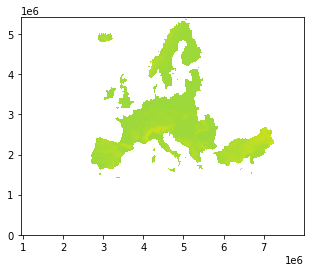

PROJCS["ETRS89_ETRS_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
2
7056
5416
BoundingBox(left=943750.0, bottom=0.0, right=7999750.0, top=5416000.0)


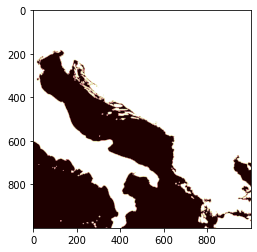

In [8]:
import rasterio 
import rasterio.plot
from rasterio.windows import Window
from matplotlib import pyplot
from osgeo import gdal

vrt_options = gdal.BuildVRTOptions(
    resampleAlg='cubic',
    xRes = 1000,
    yRes = 1000,
    addAlpha=True
)
test_vrt = gdal.BuildVRT(
    r'/mnt/z/RESEARCH/SATELLITE/DEM/test.vrt',
    files,
    options=vrt_options
)

test_vrt = None
window = Window(7056/2, 5416/2, 1000, 1000)

with rasterio.open(r'/mnt/z/RESEARCH/SATELLITE/DEM/test.vrt') as src:
    rasterio.plot.show(src)
    print(src.crs)
    print(src.count)
    print(src.width)
    print(src.height)
    print(src.bounds)
    w = src.read(1, window=window)
    # rasterio.plot.show_hist(raster_vrt)
    pyplot.imshow(w, cmap='pink')
    pyplot.show()

PROJCS["ETRS89_ETRS_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
2
7056
5416
BoundingBox(left=943750.0, bottom=0.0, right=7999750.0, top=5416000.0)
PROJCS["ETRS89_ETRS_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321

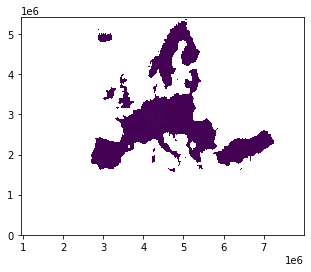

[[ 2.0000000e+00  2.0000000e+00  2.0000000e+00 ...  2.0000000e+00
   2.0000000e+00  2.0000000e+00]
 [ 2.0000000e+00  2.0000000e+00  2.0000000e+00 ...  2.0000000e+00
   2.0000000e+00  2.0000000e+00]
 [ 2.0000000e+00  2.0000000e+00  2.0000000e+00 ...  2.0000000e+00
   2.0000000e+00  2.0000000e+00]
 ...
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ...  2.0000000e+00
   2.0000000e+00  2.0000000e+00]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ...  2.0000000e+00
   2.0000000e+00  2.0000000e+00]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ...  2.0000000e+00
   2.0000000e+00  2.0000000e+00]]


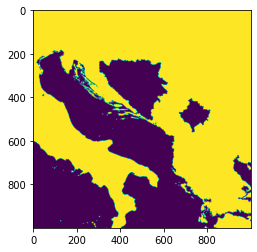

In [9]:
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio import features
from rasterio.windows import Window
from matplotlib import pyplot
from rasterio.enums import MergeAlg

shp_fn = '/mnt/z/RESEARCH/SATELLITE/NUTS/ref-nuts-2016-01m.shp/NUTS_BN_01M_2016_3035_LEVL_3.shp'
shp_fn = '/mnt/z/RESEARCH/SATELLITE/NUTS/ref-nuts-2016-01m.shp/NUTS_RG_01M_2016_3035_LEVL_3.shp'
rst_fn = '/mnt/z/RESEARCH/SATELLITE/DEM/test.tif'
out_fn = '/mnt/z/RESEARCH/SATELLITE/DEM/rasterized.tif'

counties = gpd.read_file(shp_fn)
rst = rasterio.open(rst_fn)
counties["C"] = 1
meta = rst.meta.copy()
meta.update(compress='lzw')
counties.to_crs(meta ["crs"])
with rasterio.open(out_fn, 'w+', **meta) as out:
    out_arr = out.read(1)

    shapes = ((geom,value) for geom, value in zip(counties.geometry, counties.C) if features.is_valid_geom(geom))
    
    burned = features.rasterize(
        shapes=shapes,
        fill=0,
        out=out_arr,
        transform=out.transform,
        all_touched = True,
        merge_alg = MergeAlg.replace
    )
    out.write_band(1, burned)
    shapes = ((geom,value) for geom, value in zip(counties.geometry, counties.C) if features.is_valid_geom(geom))
    burned = features.rasterize(
        shapes=shapes,
        fill=0,
        out=out_arr,
        transform=out.transform,
        all_touched = True,
        merge_alg = MergeAlg.add
    )
    out.write_band(1, burned)
    
window = Window(7056/2, 5416/2, 1000, 1000)

with rasterio.open(r'/mnt/z/RESEARCH/SATELLITE/DEM/rasterized.tif') as src:
    print(src.crs)
    print(src.count)
    print(src.width)
    print(src.height)
    print(src.bounds)

with rasterio.open(r'/mnt/z/RESEARCH/SATELLITE/DEM/test.vrt') as src:
    print(src.crs)
    print(src.count)
    print(src.width)
    print(src.height)
    print(src.bounds)

with rasterio.open(r'/mnt/z/RESEARCH/SATELLITE/DEM/rasterized.tif') as src:
    rasterio.plot.show(src)
    w = src.read(1, window=window)
    print(w)
    pyplot.imshow(w)
    pyplot.show()

In [ ]:
from osgeo import gdal

vrt_in = '/mnt/z/RESEARCH/SATELLITE/DEM/test.vrt'
tif_out = '/mnt/z/RESEARCH/SATELLITE/DEM/test.tif'
gdal.Translate(tif_out,vrt_in)

In [ ]:
import subprocess

def run_cmd(args_list):
        print('Running system command: {0}'.format(' '.join(args_list)))
        proc = subprocess.Popen(args_list, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        s_output, s_err = proc.communicate()
        s_return =  proc.returncode
        return s_return, s_output, s_err

# (ret, out, err)= run_cmd(['hdfs', 'dfs', '-put', 'local_file', 'hdfs_file_path'])
(ret, out, err)= run_cmd(['hdfs', 'dfs', '-mkdir', '/test/'])

(ret, out, err)= run_cmd(['hdfs', 'dfs', '-put', '/mnt/d/RESEARCH/SATELLITE/DEM/test.vrt', 'hdfs://169.254.151.211:9000/tmp/test.vrt'])